In [1]:
import os 
import sys 
import pandas as pd 
import numpy as np
from collections import Counter
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import datasets
from sklearn import tree
from six import StringIO
from IPython.display import Image 
import pydot
import pydotplus
sys.path.append('/Users/yantingting/PycharmProjects/modeling/')
import summary_statistics as ss
import metrics as mt 
import feature_selection as fs 
from data_io_utils import *
import data_encryption as de
import plot_tools as pt 
import data_processing as dp 
import database_conncet as dc 
# 必须要在该界面设置中文的参数
import matplotlib.pyplot as plt
from matplotlib import rcParams
plt.rcParams['font.sans-serif'] = ['STFangsong']
# plt.rcParams['font.family']=['Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False
import matplotlib.pylab as mpl


In [2]:
fs_obj = fs.FeatureSelection()
pf = mt.Performance()
bw = mt.BinWoe()

In [3]:
file_path = '/Users/yantingting/Seafile/风控/模型/10 印尼/用户画像/定位优质客群共性/data/'
file_path_result ='/Users/yantingting/Seafile/风控/模型/10 印尼/用户画像/定位优质客群共性/DecisionTree(活跃逾期)/'
if not os.path.exists(file_path_result):
    os.makedirs(file_path_result)

# 数据读取和变量衍生

In [4]:
df_1 = load_data_from_pickle(file_path,'var_all.pkl')
df_1 = df_1[df_1['freq']==1]
df_1.rename(columns = {'reg_date':'applied_at', 'dpd7+':'label'}, inplace=True)
df_1 = df_1[df_1['label'].isin([0,1])]
df_1.shape
df_1.head()

(37919, 580)

,customer_id,applied_at,age,cnt_loan,cnt_extend,max_extend,cnt_advance,is_new,max_late_days,rucui_loan,...,WPS Office,WPSOffice,WhatsApp,Wizard Penyiapan,Word,YouTube,com.mfashiongallery.emag,maucash,msa,org.codeaurora.bluetooth
3,400417947616976896,2019-11-10,32,2,0,0,0,0,-1.0,0.0,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
8,363332121556717568,2019-07-31,27,9,2,1,5,0,1.0,2.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
15,362246454961545216,2019-07-28,31,7,3,3,4,0,1.0,2.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
22,312270189899059200,2019-03-12,29,9,0,0,2,0,1.0,1.0,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
24,312273006260953088,2019-03-12,55,6,0,0,5,0,-1.0,0.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [5]:
var_dict = pd.read_csv(os.path.join(file_path,'var_dict_all.csv'))
useless_cols = ['applied_at','is_new','freq','customer_id', 'profit_rmb','max_late_days','label',
               'cnt_loan', 'cnt_extend', 'max_extend', 'cnt_advance', 'max_late_days', 'rucui_loan',
                'rucui_order','ConfigUpdater','UKU','media_source_']
Y_col = 'label'
X_col = list(set(df_1.columns).difference(useless_cols))
len(X_col)

564

# 拆分数据集

In [6]:
from sklearn.model_selection import train_test_split
df = df_1
X_train, X_test, y_train, y_test = train_test_split(df, df[Y_col], test_size=0.25, 
                        random_state=1,shuffle = True, stratify = df[Y_col])
df_train =  X_train
df_train['sample_flag'] = 0
df_train.shape
df_test =  X_test
df_test['sample_flag'] = 1

X_train = df_train[X_col]
X_test= df_test[X_col]

Counter(y_train)
Counter(y_test)
print("X_train_shape:", X_train.shape, " y_train_shape:", y_train.shape)
print("X_test_shape:", X_test.shape,"  y_test_shape:", y_test.shape)

/Users/yantingting/opt/anaconda3/envs/modeling/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


(28439, 581)

/Users/yantingting/opt/anaconda3/envs/modeling/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


Counter({0.0: 26080, 1.0: 2359})

Counter({0.0: 8693, 1.0: 787})

X_train_shape: (28439, 564)  y_train_shape: (28439,)
X_test_shape: (9480, 564)   y_test_shape: (9480,)


# 可视化

In [7]:
fig_path =  os.path.join(file_path_result, 'fig')
if not os.path.exists(fig_path):
    os.makedirs(fig_path)

{0: 'msa',
 1: 'brand_google',
 2: 'districtcode_31',
 3: 'brand_evercoss-a75l',
 4: 'Facebook App Manager',
 5: 'brand_spc',
 6: 'brand_vertu',
 7: 'Indodana',
 8: 'brand_doogee',
 9: 'media_source_bytedanceglobal_int',
 10: 'districtcode_07',
 11: 'brand_leagoo',
 12: 'brand_hotwav',
 13: 'Shopintar',
 14: 'brand_evercoss a74a',
 15: 'brand_plus',
 16: 'GooglePlayStore',
 17: 'religion_Kristen',
 18: 'citycode_28',
 19: 'brand_ken',
 20: 'provincecode_92',
 21: 'V-Appstore',
 22: 'media_source_inmobi_int',
 23: 'media_source_affle_int',
 24: 'brand_nokia',
 25: 'districtcode_04',
 26: 'brand_advan',
 27: 'Pembayaran aman',
 28: 'media_source_accesstradeid_int',
 29: 'ShareMe',
 30: 'districtcode_01',
 31: 'marital_status_Kawin',
 32: 'brand_umidigi',
 33: 'marital_status_',
 34: 'provincecode_52',
 35: 'brand_iphone',
 36: 'KreditPintar',
 37: 'media_source_recall_12',
 38: 'brand_sugar',
 39: 'districtcode_25',
 40: 'districtcode_34',
 41: 'Hangouts',
 42: 'citycode_11',
 43: 'brand

/Users/yantingting/opt/anaconda3/envs/modeling/lib/python3.7/site-packages/sklearn/tree/_classes.py:319: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter.
  FutureWarning)


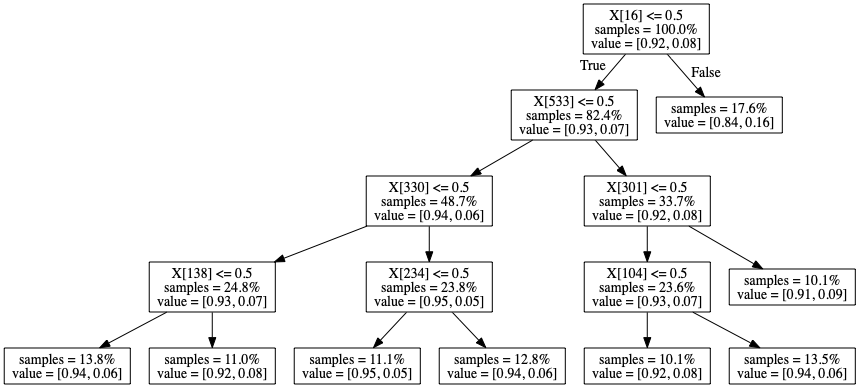

True

In [8]:
var_tree = X_col
var_rank = dict(zip(range(len(var_tree)+1),var_tree))
var_rank
pd.DataFrame.from_dict(var_rank, orient='index').to_excel(os.path.join(file_path_result,'var_rank.xlsx'))
clf = tree.DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=0.1, min_samples_split=0.01,
                       min_weight_fraction_leaf=0.0, presort=True,
                       random_state=None, splitter='best')
clf = clf.fit(X_train, y_train)

dot_data = StringIO()  
tree.export_graphviz(clf, out_file=dot_data, proportion=True,
                     impurity = False,precision=2)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 
Image(graph.create_png()) 
graph.write_png(os.path.join(file_path_result , 'tree.png'))

# 变量重要性

In [9]:
features_in_model = X_col
feature_importance = clf.feature_importances_
var_importance = pd.DataFrame(columns=["指标英文", 'importance'])
var_importance['指标英文'] = features_in_model
var_importance['importance'] = feature_importance
var_importance.loc[:, 'importance_rank'] = var_importance.importance.rank(ascending=False)
var_importance.sort_values(by = 'importance',ascending = False,inplace = True)
var_importance.to_excel(os.path.join(file_path_result,'var_importance.xlsx'))
var_importance.head(10)

,指标英文,importance,importance_rank
16,GooglePlayStore,0.898715,1.0
533,education_SENIOR_HIGH_SCHOOL,0.033489,2.0
330,UangMe,0.017945,3.0
301,Pinjam Yuk,0.016514,4.0
138,Penyiapan Mitra Google,0.014055,5.0
104,Kredit Pintar,0.010297,6.0
234,Messenger,0.008985,7.0
0,msa,0.000000,286.0
379,Agen Masukan Market,0.000000,286.0
376,MesinGoogleText-to-speech,0.000000,286.0


In [10]:
train_score = clf.score(X_train, y_train)
test_score = clf.score(X_test, y_test)
train_score
test_score

0.9170505292028552

0.9169831223628692

# 结果

In [11]:
y_train_pred = clf.predict_proba(X_train)[:,1]
y_train_pred.shape
y_test_pred = clf.predict_proba(X_test)[:,1]
y_test_pred.shape
# ### 打分&KS
train_pred = df_train.copy()
train_pred['y_pred'] = y_train_pred

test_pred = df_test.copy()
test_pred['y_pred'] = y_test_pred
data_scored_train, train_proba_ks, train_proba_ks_20, train_score_ks, train_score_ks_20, data_scored_test, test_proba_ks, test_proba_ks_20, test_score_ks, test_score_ks_20 = pf.data_score_KS(train_pred, test_pred, 'y_pred')

writer = pd.ExcelWriter(os.path.join(file_path_result,'ks.xlsx'))
train_score_ks.to_excel(writer,sheet_name = 'train_score_ks')
test_score_ks.to_excel(writer, sheet_name = 'test_score_ks') 
writer.close()

def auc_acc_table(df):
    from sklearn.metrics import roc_auc_score
    from sklearn.metrics import accuracy_score
    y = df.label.values
    y_pred = df.y_pred
    ## AUC
    auc = roc_auc_score(y, y_pred)
    print("auc: %.2f" % auc)
    ## Accuracy
    predictions = [round(value) for value in y_pred]
    accuracy = accuracy_score(y, predictions)
    print("Accuracy: %.4f%%" % (accuracy * 100.0))
    return auc, accuracy

auc_train, acc_train = auc_acc_table(train_pred)
auc_test, acc_test = auc_acc_table(test_pred)
print('success')

(28439,)

(9480,)

/Users/yantingting/opt/anaconda3/envs/modeling/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


auc: 0.62
Accuracy: 91.7051%
auc: 0.61
Accuracy: 91.6983%
success


# LiftChart

,order_no,Y,y_pred,score,score_bin,score_bin_20,proba_bin,proba_bin_20,sample_set
0,88304,0.0,0.064563,677.0,"(670.0, 677.0]","(670.0, 677.0]","(0.0627985, 0.0645628]","(0.0627985, 0.0645628]",train
1,140908,0.0,0.156468,649.0,"(648.0, 669.0]","(648.0, 669.0]","(0.0845287, 0.156468]","(0.0845287, 0.156468]",train
2,132424,0.0,0.084529,669.0,"(648.0, 669.0]","(648.0, 669.0]","(0.0813981, 0.0845287]","(0.0813981, 0.0845287]",train
3,67245,0.0,0.062799,678.0,"(677.0, 678.0]","(677.0, 678.0]","(0.0507485, 0.0627985]","(0.0507485, 0.0627985]",train
4,92352,1.0,0.156468,649.0,"(648.0, 669.0]","(648.0, 669.0]","(0.0845287, 0.156468]","(0.0845287, 0.156468]",train


/Users/yantingting/PycharmProjects/modeling/plot_tools.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bkl_%s' % y_pred] = pd.qcut(df[y_pred], n_bins, duplicates='drop')


分箱数量:  5


/Users/yantingting/PycharmProjects/modeling/plot_tools.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bkl_%s' % y_pred] = pd.qcut(df[y_pred], n_bins, duplicates='drop')
/Users/yantingting/PycharmProjects/modeling/plot_tools.py:84: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1, 2, 1)
/Users/yantingting/PycharmProjects/modeling/plot_tools.py:96: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reu

分箱数量:  5


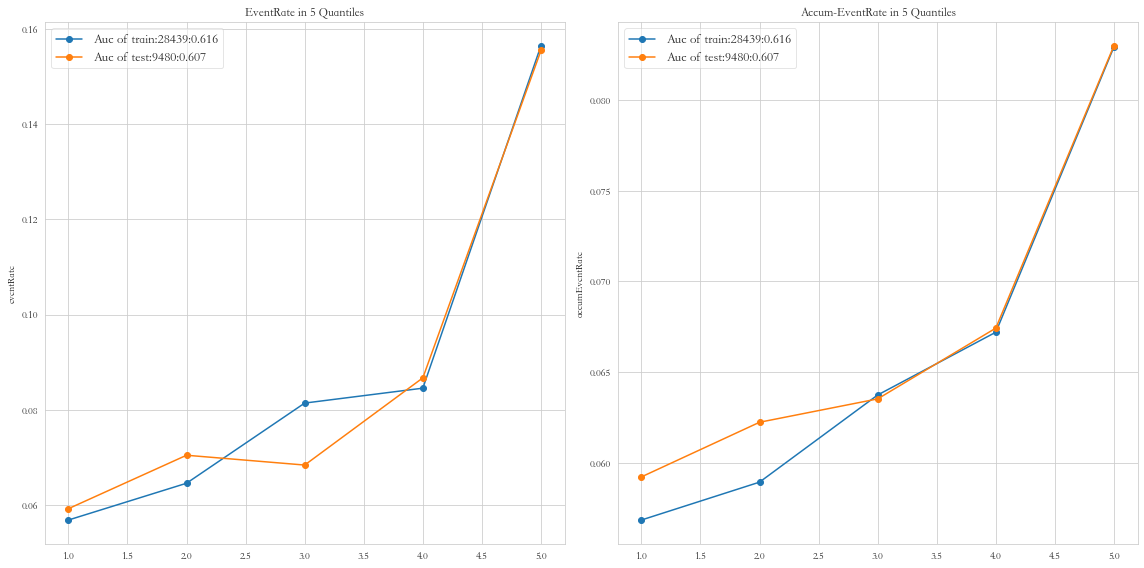

end


In [12]:
data_scored_train['sample_set'] = "train"
data_scored_test['sample_set'] = "test"
data_scored_all = pd.concat([data_scored_train, data_scored_test])
data_scored_all['order_no'] = data_scored_all['order_no'].astype(str)
data_scored_all.head()
save_data_to_pickle(data_scored_all,file_path_result,'data_scored_all.pkl')

FIG_PATH = os.path.join(file_path_result, 'figure', 'liftchart')
if not os.path.exists(FIG_PATH):
    os.makedirs(FIG_PATH)

train_lc = pt.show_result_new(data_scored_all.loc[data_scored_all.sample_set == 'train'], 'y_pred','Y', n_bins = 10, feature_label='train')
test_lc = pt.show_result_new(data_scored_all.loc[data_scored_all.sample_set == 'test'], 'y_pred','Y', n_bins = 10, feature_label='test')
# oot_lc = pt.show_result_new(data_scored_all.loc[data_scored_all.sample_set == 'oot'], 'y_pred','Y', n_bins = 10, feature_label='oot')
path = os.path.join(FIG_PATH, "LiftChart.png")
plt.savefig(path, format='png', dpi=300, bbox_inches = 'tight',pad_inches = 0.1)
plt.show()
plt.close()

print('end')